Found 10215 files
First 3 files names:
['/media/rodrigoa/Andresito/FBK_Preproduccion/247/SET2/SPE/C2--OV7--02115.txt', '/media/rodrigoa/Andresito/FBK_Preproduccion/247/SET2/SPE/C2--OV7--06467.txt', '/media/rodrigoa/Andresito/FBK_Preproduccion/247/SET2/SPE/C2--OV7--00000.txt']


Text(0.5, 1.0, 'SiPM overvoltage: 7V')

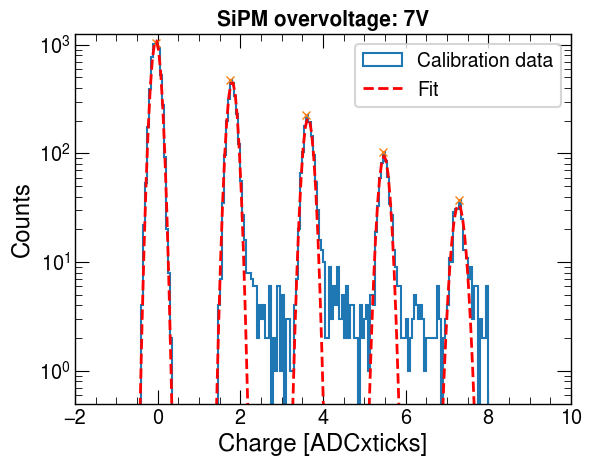

In [13]:
# %%
import numpy as np
import matplotlib.pyplot as plt
import awkward as ak

import SBNDstyle
import matplotlib.pyplot as plt
plt.style.use('SBND.mplstyle')
import glob
import argparse
import os
import pandas as pd

e_charge=1.60217662e-19
Amplification=498.1985837964828

# %%

OV=7
# file_list='/media/rodrigoa/Andresito/FBK_Preproduccion/247/SET2/SPE/C2--OV'+str(OV)+'--**'
file_list = glob.glob('/media/rodrigoa/Andresito/FBK_Preproduccion/247/SET2/SPE/C2--OV7--**')

# print('Reading files in :'+fi+'...')

print('Found {} files'.format(len(file_list)))
print('First 3 files names:')
print(file_list[:3])

DEBUG =False

file1_path = file_list[0]
HEADER=3
N_SEGMENTs=50
PRETRIGGER=5e-6 #in s

def SPE_get_ADCs_file(file_path):
    ADCs=np.loadtxt(file_path, delimiter=',', skiprows=5)
    period=ADCs[1,0]-ADCs[0,0]
    ADCs=ADCs[:,1]
    return ADCs,period

    
def SPE_get_ADCs_file_list(file_list,polarity=1,PED_RANGE=250):
    ADCs_list=[]
    for file_path in file_list:
        ADCs,period=SPE_get_ADCs_file(file_path)
        ADCs_list.append(ADCs)
    ADCs=np.array(ADCs_list)
    
    ADCs = (ADCs.T - np.mean(ADCs[:, :PED_RANGE], axis=1).T).T
    ADCs*=polarity
    return ADCs,period


ADCs, period= SPE_get_ADCs_file_list(file_list)

# DEBUG=True
if DEBUG:
    for i in range(10):
        plt.plot(ADCs[i,:])
        
    plt.figure()
    avg_ADCs=np.mean(ADCs,axis=0)
    plt.plot(avg_ADCs)
    plt.semilogy()

# %%
from scipy.optimize import curve_fit

#functions:
def gauss(x,a,x0,sigma):
    return a*np.exp(-0.5*np.power((x-x0)/sigma,2))

def gaussian_train(x, *params):
    y = np.zeros_like(x)
    for i in range(0, len(params), 3):
        height = params[i]
        center = params[i+1]
        width  = params[i+2]
        y      +=  gauss(x, height, center, width)
    return y

def fit_gaussians(x, y, *p0):
    assert x.shape == y.shape, "Input arrays must have the same shape."
    # try:
    popt, pcov = curve_fit(gaussian_train, x,y, p0=p0[0])
    fit_y=gaussian_train(x,*popt)
    chi_squared = np.sum((y[abs(fit_y)>0.1] - fit_y[abs(fit_y)>0.1]) ** 2 / fit_y[abs(fit_y)>0.1]) / (y.size - len(popt))
    # plt.figure(dpi=200, figsize=(6, 3))
    # fig = plt.axes()
    # plt.plot(x, y, 'b-', label='data')
    # plt.plot(x, fit_y, 'r-', label='fit',linewidth=1)
    # plt.grid()
    return popt,fit_y, chi_squared
    # except:
    #     print("Fit failed.")
    
def Q_out(V_out,period):
    #   V_out in Volts
    #          osc resistance    x  t
    q=V_out  /      50          *   period
    return q



# %%
charge= np.sum(ADCs[:,200:],axis=1)


from scipy.signal import find_peaks
# Find peaks in the charge histogram
# plt.hist(charge3,bins=300,histtype='step');

# plt.semilogy()

plt.xlim(-2,10)

# plt.semilogy()
Bins=200
r=[-2,8]
# if OV==7 and DEBUG:
#     r=[-2,10]


counts,bins,_=plt.hist(charge ,bins=Bins,range=r,histtype='step',label="Calibration data");

#find peaks
peaks=find_peaks(counts,height=10,width=2,distance=6)

plt.plot(bins[peaks[0]], counts[peaks[0]], "x")
if DEBUG:plt.show()
#right limit:(supossing same space between peaks, prevents adding more gaussians that the ones considered to be fitted)
r_lim=peaks[0][-1]+ int (((peaks[0][-1]-peaks[0][-2]))/2)

l_lim=peaks[0][0]- int (((peaks[0][1]-peaks[0][0]))/2)-2
if l_lim<0:
    l_lim=0
std=(bins[peaks[0]][1]-bins[peaks[0]][0])/4

params=np.zeros(len(peaks[0])*3)
params[0::3]=peaks[1]["peak_heights"]
params[1::3]=bins[peaks[0]]
params[2::3]=std

if  DEBUG:
    
    print("params",params)
    print()
    print("l_lim: "+str(l_lim))
    print()
    print("r_lim: "+str(r_lim))
    print()
    print("std: "+str(std))
    print()
    print("bins: "+str(bins[peaks[0]]))
    print()
    print("counts: "+str(counts[peaks[0]]))
    print()
    
vars,fit_y,qs=fit_gaussians(bins[:-1][l_lim:r_lim],counts[l_lim:r_lim],params)

plt.plot(bins[:-1][l_lim:r_lim] +(bins[1]-bins[0])/2  ,fit_y,'--',color="red",label="Fit")
plt.legend()
plt.xlabel("Charge [ADCxticks]")
plt.ylabel("Counts")
# plt.xlim( bins[peaks[0]][0]-2*half,bins[peaks[0]][-1]+5*half)

x = bins[:-1][l_lim:r_lim] + (bins[1] - bins[0]) / 2

# for i in range(0, len(vars), 3):
#     height = vars[i]
#     center = vars[i + 1]
#     width = vars[i + 2]
#     gaussian = gauss(x, height, center, width)
#     plt.plot(x, gaussian, color="tab:green")

plt.ylim(0.5,counts[peaks[0]][0]*1.2)

plt.legend(frameon=True,fontsize=14)

plt.semilogy()

# %%
##save the data

gain_ADCs_x_ticks     = np.mean(vars[1::3][1:]-vars[1::3][:-1])
gain_ADCs_x_ticks_std = np.std (vars[1::3][1:]-vars[1::3][:-1])
error_relative=gain_ADCs_x_ticks/gain_ADCs_x_ticks_std

gain_absolute=Q_out(gain_ADCs_x_ticks,period)/e_charge/1e6/Amplification
gain_absolute_error=gain_absolute*error_relative

plt.title("SiPM overvoltage: "+str(OV)+'V',fontsize=15,fontweight='bold')


In [9]:
DEBUG=False
#Compute Gaussian areas
Amp=vars[0::3]
sigma=np.abs(vars[2::3])

#prob is proportional to A*sigma (sqrt(2pi))
PNs=Amp*sigma/sum(Amp*sigma)

#assuming error propt to sqrt(N)
PNs_err=(Amp*sigma)**0.5/sum(Amp*sigma)

if DEBUG:
    print(Amp)
    print(sigma)
    print(PNs,PNs.sum())
    print(PNs_err)

P0=PNs[0]
P1=PNs[1]
l=-np.log(P0)
p=1-P1/(l*P0)
print("Initial vars:",p,"\t",l)


Initial vars: 0.24950563932168401 	 0.5790639527633544


In [10]:
##Binomial+Poisson distribution

from math import factorial as fact
import numpy as np
from scipy.stats import poisson
def B(i,k):
    #factorial factor of F
    if (i==0) & (k==0):return 1;
    if (i==0) & (k>0): return 0;
    else:
        return (fact(k-1) * fact(k)
                /(fact(i-1)*fact(i)*fact(k-i) )
               )

def F(K,p,L):
    ## computes prob of the kth point in a convoluted poisson+binomial distribution, 
    # L is the mean value of the poisson, p is the binomial coef, i.e. the crosstalk we want to compute
    

    aux_sum=0
    if DEBUG: print(K)
    for i in range(K+1):
        aux_sum+=B(i,K)*((L *(1 - p))**i)  *  (p**(K - i)) 

    return np.exp(-L)*aux_sum/fact(K);

def PoissonPlusBinomial(x,p,L):
    N=len(x)
    aux=np.zeros(shape=N)
    for i in range(N):
        if DEBUG: print(x,i,x[i])
        aux[i]= F(int(x[i]),p,L);
    
    return aux/sum(aux);


Fitted vars:  [0.27000183 0.59527467]
Rel Error:  [1.00878306 0.40540599]


Text(0.5, 1.0, 'SiPM overvoltage: 7V')

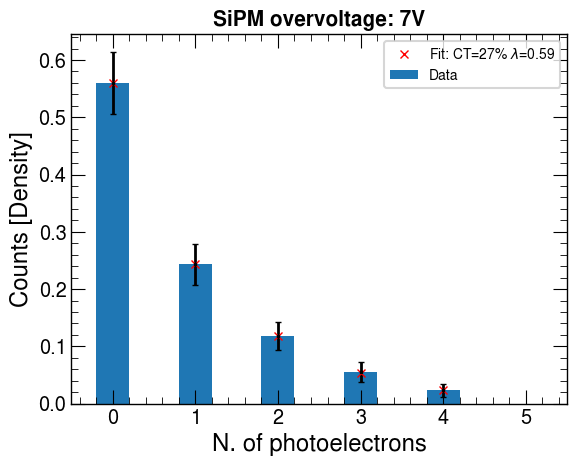

In [11]:
# 2nd plot, Vinogradov fit
# fig, ax = plt.subplots(1,dpi=200,figsize=(5,3))

plt.xlim([-.5,5.5]) 
# Get the peaks that were fitted
a=np.arange(Bins)*(r[1]-r[0])/Bins
b=bins[peaks[0]]
b=b/(b[1]-b[0])

xdata=b.round().astype(int).tolist()
if DEBUG: print(b,xdata)


plt.errorbar(x=xdata,y=PNs,yerr=PNs_err, color="k",linestyle="none",marker="s",markersize=2,capsize=2,)
plt.bar(np.array(xdata),PNs,label="Data",width=0.4)

p0=[p,l]
popt, pcov = curve_fit(PoissonPlusBinomial, xdata,PNs,sigma=PNs_err, p0=p0)

plt.plot(xdata, PoissonPlusBinomial(xdata, *popt), 'x',label="Fit: CT=" +str(int(popt[0]*100)) +"% $\lambda$="+str(int(popt[1]*100)/100),color="red")

plt.ylabel("Counts [Density]")
plt.xlabel("N. of photoelectrons")
plt.legend(fontsize=10,frameon=True)
# Display also the ideal poisson dist
# ideal=poisson.pmf(xdata, mu=popt[1])
# plt.bar(np.array(xdata)+.3,ideal,width=.3)

print("Fitted vars: ",popt)
perr = np.sqrt(np.diag(pcov))
print("Rel Error: ", perr/popt*100)
plt.title("SiPM overvoltage: "+str(OV)+'V',fontsize=15,fontweight='bold')
